Reading D:\FY2025\Fukuyama\work place\preprocessed_data\sub-010002_EC.fdt
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 501 original time points ...
0 bad epochs dropped
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


C:\Users\sFukuyama\AppData\Local\Temp\7\ipykernel_36980\3798196800.py:6: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab('D:\\FY2025\\Fukuyama\\work place\\preprocessed_data\\sub-010002_EC.set')
C:\Users\sFukuyama\AppData\Local\Temp\7\ipykernel_36980\3798196800.py:6: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('D:\\FY2025\\Fukuyama\\work place\\preprocessed_data\\sub-010002_EC.set')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


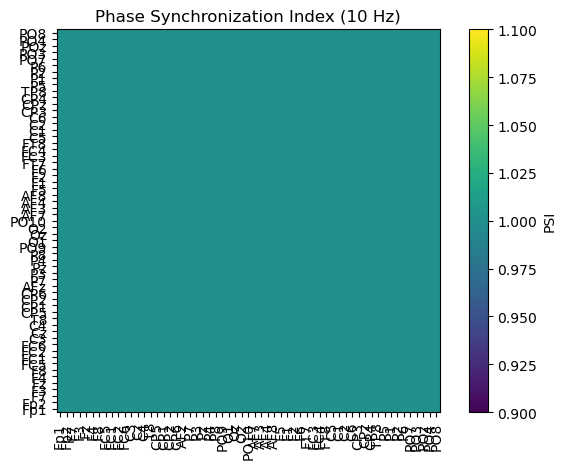

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# ===== Raw 読み込みとエポック化（前の手順と同じ） =====
raw = mne.io.read_raw_eeglab('D:\\FY2025\\Fukuyama\\work place\\preprocessed_data\\sub-010002_EC.set')
raw.crop(tmax=60)
raw.pick_types(eeg=True)

events = mne.make_fixed_length_events(raw, id=1, duration=2.0)
epochs = mne.Epochs(raw, events, event_id=1, tmin=0.0, tmax=2.0,
                    baseline=None, preload=True)

# ===== Morlet wavelet変換 =====
freqs = [10]  # 例：10Hzのみで同期を見る
n_cycles = 5

power = mne.time_frequency.tfr_morlet(
    epochs, freqs=freqs, n_cycles=n_cycles,
    use_fft=True, return_itc=False, average=False
)

# ===== 位相抽出（1周波数なので次元削減）=====
phase_data = np.angle(power.data)  # shape: (n_epochs, n_channels, n_freqs, n_times)
phase = phase_data[:, :, 0, :]     # shape: (n_epochs, n_channels, n_times)

# ===== PSI（PLVと同等）を計算（1エポック分を平均）=====
n_channels = phase.shape[1]
n_epochs = phase.shape[0]
n_times = phase.shape[2]

psi_matrix = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase[:, i, :] - phase[:, j, :]
        complex_phase_diff = np.exp(1j * phase_diff)
        psi = np.abs(np.mean(complex_phase_diff))
        psi_matrix[i, j] = psi

# ===== PSI行列の可視化 =====
plt.imshow(psi_matrix, cmap='viridis', origin='lower')
plt.colorbar(label="PSI")
plt.title("Phase Synchronization Index (10 Hz)")
plt.xticks(ticks=np.arange(n_channels), labels=raw.ch_names, rotation=90)
plt.yticks(ticks=np.arange(n_channels), labels=raw.ch_names)
plt.tight_layout()
plt.show()
